In [491]:
import numpy as np
import matplotlib.pyplot as plt

### Dataset

#### Well-formedness rules

1. Start with 1
2. Forbid 00100 (no 100, 001 on the boundary)
3. Forbid 0000


In [281]:
n = 10
well_formed_set = np.zeros([1,10])
well_formed_set[0,0] = 1

for i in range(1,n):
    for j in range(np.shape(well_formed_set)[0]):
        if i == 2 and np.array_equal(well_formed_set[j,i-2:i], [1,0]):
            well_formed_set[j,i] = 1
        elif i > 3 and np.array_equal(well_formed_set[j,i-3:i], [0,0,0]):
            well_formed_set[j,i] = 1
        elif i > 3 and np.array_equal(well_formed_set[j,i-4:i], [0,0,1,0]):
            well_formed_set[j,i] = 1
        else:
            well_formed_set = np.append(well_formed_set, well_formed_set[j:j+1,:], axis=0)
            well_formed_set[j,i] = 1
            
ind = np.array([], dtype=np.int8)
for i in range(well_formed_set.shape[0]):
    if np.array_equal(well_formed_set[i,-3:], [0,0,1]):
        ind = np.append(ind,i)

well_formed_set = np.delete(well_formed_set,ind,0)
well_formed_set = (well_formed_set - 0.5)*2
well_formed_set

array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1., -1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1., -1., ...,  1.,  1.,  1.],
       ...,
       [ 1.,  1.,  1., ..., -1., -1., -1.],
       [ 1., -1.,  1., ..., -1., -1., -1.],
       [ 1.,  1., -1., ..., -1., -1., -1.]])

In [282]:
well_formed_set.shape

(256, 10)

In [283]:
well_formed_set[165,:]

array([ 1.,  1., -1.,  1., -1., -1., -1.,  1.,  1., -1.])

In [284]:
train_set = np.transpose(well_formed_set)
train_set.shape

(10, 256)

### Functions

In [285]:
def sigmoid(x):
    y = 1/(1+np.exp(-x))
    return y

In [286]:
def wake_forward(data,Phi_12,Phi_23,Phi_34,b_12,b_23,b_34,n_x,n_y,n_z):
    q_2 = sigmoid(np.matmul(Phi_12,data) + b_12)
    x = ((q_2 > np.random.rand(n_x,1)).astype(int) - 0.5)*2    # rejection sampling
    # x = np.where(q_2 > 0.5,1,-1)  # deterministic
    
    q_3 = sigmoid(np.matmul(Phi_23,x) + b_23)
    y = ((q_3 > np.random.rand(n_y,1)).astype(int) - 0.5)*2
    
    q_4 = sigmoid(np.matmul(Phi_34,y) + b_34)
    z = ((q_4 > np.random.rand(n_z,1)).astype(int) - 0.5)*2
    
    Q_2 = (np.cumprod(q_2[np.where(x == 1)])[-1] if q_2[np.where(x == 1)].size != 0 else 1) * (np.cumprod(1-q_2[np.where(x == -1)])[-1] if q_2[np.where(x == -1)].size != 0 else 1)*(1.5**n_x)
    Q_3 = (np.cumprod(q_3[np.where(y == 1)])[-1] if q_3[np.where(y == 1)].size != 0 else 1) * (np.cumprod(1-q_3[np.where(y == -1)])[-1] if q_3[np.where(y == -1)].size != 0 else 1)*(1.5**n_y)
    Q_4 = (np.cumprod(q_4[np.where(z == 1)])[-1] if q_4[np.where(z == 1)].size != 0 else 1) * (np.cumprod(1-q_4[np.where(z == -1)])[-1] if q_4[np.where(z == -1)].size != 0 else 1)*(1.5**n_z)
    Q = Q_2 * Q_3 * Q_4
    
    return q_2,q_3,q_4,x,y,z,Q

In [287]:
def sleep_forward(Theta,Theta_43,Theta_32,Theta_21,b_43,b_32,b_21,n_z,n_y,n_x,n_d):
    p_4 = sigmoid(Theta)
    z = ((p_4 > np.random.rand(n_z,1)).astype(int) - 0.5)*2    # rejection sampling
    
    p_3 = sigmoid(np.matmul(Theta_43,z) + b_43)
    y = ((p_3 > np.random.rand(n_y,1)).astype(int) - 0.5)*2
    
    p_2 = sigmoid(np.matmul(Theta_32,y) + b_32)
    x = ((p_2 > np.random.rand(n_x,1)).astype(int) - 0.5)*2
    
    p_1 = sigmoid(np.matmul(Theta_21,x) + b_21)
    d = ((p_1 > np.random.rand(n_d,1)).astype(int) - 0.5)*2  # sampling
    # d = np.where(p_1 > 0.5,1,-1)  # deterministic
    
    P_4 = (np.cumprod(p_4[np.where(z == 1)])[-1] if p_4[np.where(z == 1)].size != 0 else 1)* (np.cumprod(1-p_4[np.where(z == -1)])[-1] if p_4[np.where(z == -1)].size != 0 else 1)*(1.5**n_z)
    P_3 = (np.cumprod(p_3[np.where(y == 1)])[-1] if p_3[np.where(y == 1)].size != 0 else 1)* (np.cumprod(1-p_3[np.where(y == -1)])[-1] if p_3[np.where(y == -1)].size != 0 else 1)*(1.5**n_y)
    P_2 = (np.cumprod(p_2[np.where(x == 1)])[-1] if p_2[np.where(x == 1)].size != 0 else 1)* (np.cumprod(1-p_2[np.where(x == -1)])[-1] if p_2[np.where(x == -1)].size != 0 else 1)*(1.5**n_x)
    P_1 = (np.cumprod(p_1[np.where(d == 1)])[-1] if p_1[np.where(d == 1)].size != 0 else 1)* (np.cumprod(1-p_1[np.where(d == -1)])[-1] if p_1[np.where(d == -1)].size != 0 else 1)*(1.5**n_d)
    
    P = P_1 * P_2 * P_3 * P_4
    
    return p_4,p_3,p_2,p_1,z,y,x,d,P

In [288]:
def wake_update_delta(z,y,x,d,Theta,Theta_43,Theta_32,Theta_21,b_43,b_32,b_21,lr):
    p_4 = sigmoid(Theta)
    Theta -= lr * (p_4 - (1+z)/2)
    
    p_3 = sigmoid(np.matmul(Theta_43,z) + b_43)
    Theta_43 -= lr * np.outer((p_3 - (1+y)/2), z)
    b_43 -= lr * (p_3 - (1+y)/2)
    
    p_2 = sigmoid(np.matmul(Theta_32,y) + b_32)
    Theta_32 -= lr * np.outer((p_2 - (1+x)/2), y)
    b_32 -= lr * (p_2 - (1+x)/2)
    
    p_1 = sigmoid(np.matmul(Theta_21,x) + b_21)
    Theta_21 -= lr * np.outer((p_1 - (1+d)/2), x)
    b_21 -= lr * (p_1 - (1+d)/2)
    
    return Theta,Theta_43,Theta_32,Theta_21,b_43,b_32,b_21

In [289]:
def sleep_update_delta(z,y,x,d,Phi_12,Phi_23,Phi_34,b_12,b_23,b_34,lr):
    
    q_2 = sigmoid(np.matmul(Phi_12,d) + b_12)
    Phi_12 -= lr * np.outer((q_2 - (1+x)/2), d)
    b_12 -= lr * (q_2 - (1+x)/2)
    
    q_3 = sigmoid(np.matmul(Phi_23,x) + b_23)
    Phi_23 -= lr * np.outer((q_3 - (1+y)/2), x)
    b_23 -= lr * (q_3 - (1+y)/2)
    
    q_4 = sigmoid(np.matmul(Phi_34,y) + b_34)
    Phi_34 -= lr * np.outer((q_4 - (1+z)/2), y)
    b_34 -= lr * (q_4 - (1+z)/2)
    
    return Phi_12,Phi_23,Phi_34,b_12,b_23,b_34

### Parameter Initialization

In [290]:
n_z = 3
n_y = 5
n_x = 8
n_d = 10

In [291]:
# Random initialization

Phi_12 = np.random.rand(n_x,n_d) *2-1
Phi_23 = np.random.rand(n_y,n_x) *2-1
Phi_34 = np.random.rand(n_z,n_y) *2-1
b_12 = np.random.rand(n_x,1) *2-1
b_23 = np.random.rand(n_y,1) *2-1
b_34 = np.random.rand(n_z,1) *2-1

Theta = np.random.rand(n_z,1) *2-1
Theta_43 = np.random.rand(n_y,n_z) *2-1
Theta_32 = np.random.rand(n_x,n_y) *2-1
Theta_21 = np.random.rand(n_d,n_x) *2-1
b_43 = np.random.rand(n_y,1) *2-1
b_32 = np.random.rand(n_x,1) *2-1
b_21 = np.random.rand(n_d,1) *2-1

In [292]:
# Zero initialization

Phi_12 = np.zeros((n_x,n_d))
Phi_23 = np.zeros((n_y,n_x))
Phi_34 = np.zeros((n_z,n_y))
b_12 = np.zeros((n_x,1))
b_23 = np.zeros((n_y,1))
b_34 = np.zeros((n_z,1))

Theta = np.zeros((n_z,1))
Theta_43 = np.zeros((n_y,n_z))
Theta_32 = np.zeros((n_x,n_y))
Theta_21 = np.zeros((n_d,n_x))
b_43 = np.zeros((n_y,1))
b_32 = np.zeros((n_x,1))
b_21 = np.zeros((n_d,1))

In [293]:
print ("Phi_12: " + str(Phi_12))
#print ("Phi_23: " + str(Phi_23))
#print ("Phi_34: " + str(Phi_34))
#print ("b_12: " + str(b_12))
#print ("b_23: " + str(b_23))
#print ("b_34: " + str(b_34))

Phi_12: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [294]:
print ("Theta: " + str(Theta))
#print ("Theta_43: " + str(Theta_43))
#print ("Theta_32: " + str(Theta_32))
#print ("Theta_21: " + str(Theta_21))
#print ("b_43: " + str(b_43))
#print ("b_32: " + str(b_32))
#print ("b_21: " + str(b_21))

Theta: [[0.]
 [0.]
 [0.]]


### Training

In [295]:
train_set.shape

(10, 256)

In [298]:
lr = 0.01
epoch = 100

In [320]:
Phi_12_cache = np.copy(Phi_12)
Phi_23_cache = np.copy(Phi_23)
Phi_34_cache = np.copy(Phi_34)
b_12_cache = np.copy(b_12)
b_23_cache = np.copy(b_23)
b_34_cache = np.copy(b_34)

Theta_cache = np.copy(Theta)
Theta_43_cache = np.copy(Theta_43)
Theta_32_cache = np.copy(Theta_32)
Theta_21_cache = np.copy(Theta_21)
b_43_cache = np.copy(b_43)
b_32_cache = np.copy(b_32)
b_21_cache = np.copy(b_21)

In [387]:
# Sample-based training
# Local delta rule
for e in range(epoch):
    num_samples = train_set.shape[1]
    train_set = train_set[:,np.random.permutation(num_samples)]
    
    for i in range(num_samples):
        data = train_set[:,i:i+1]
        q_2,q_3,q_4,x_w,y_w,z_w,Q = wake_forward(data,Phi_12,Phi_23,Phi_34,b_12,b_23,b_34,n_x,n_y,n_z)
        Theta,Theta_43,Theta_32,Theta_21,b_43,b_32,b_21 = wake_update_delta(z_w,y_w,x_w,data,Theta,Theta_43,Theta_32,Theta_21,b_43,b_32,b_21,lr)
        p_4,p_3,p_2,p_1,z_s,y_s,x_s,d_s,P = sleep_forward(Theta,Theta_43,Theta_32,Theta_21,b_43,b_32,b_21,n_z,n_y,n_x,n_d)
        Phi_12,Phi_23,Phi_34,b_12,b_23,b_34 = sleep_update_delta(z_s,y_s,x_s,d_s,Phi_12,Phi_23,Phi_34,b_12,b_23,b_34,lr)

    recog_phi = np.sum((Phi_12 - Phi_12_cache)**2) + np.sum((Phi_23 - Phi_23_cache)**2) + np.sum((Phi_34 - Phi_34_cache)**2) 
    recog_b = np.sum((b_12 - b_12_cache)**2) + np.sum((b_23 - b_23_cache)**2) + np.sum((b_34 - b_34_cache)**2)
    gener_theta = np.sum((Theta - Theta_cache)**2) + np.sum((Theta_43 - Theta_43_cache)**2) + np.sum((Theta_32 - Theta_32_cache)**2) + np.sum((Theta_21 - Theta_21_cache)**2)
    gener_b = np.sum((b_43 - b_43_cache)**2) + np.sum((b_32 - b_32_cache)**2) + np.sum((b_21 - b_21_cache)**2)
    print ("recog_phi: " + str(recog_phi))
    print ("recog_b: " + str(recog_b))
    print ("gener_theta: " + str(gener_theta))
    print ("gener_b: " + str(gener_b))
    print('')
    
    Phi_12_cache = np.copy(Phi_12)
    Phi_23_cache = np.copy(Phi_23)
    Phi_34_cache = np.copy(Phi_34)
    b_12_cache = np.copy(b_12)
    b_23_cache = np.copy(b_23)
    b_34_cache = np.copy(b_34)

    Theta_cache = np.copy(Theta)
    Theta_43_cache = np.copy(Theta_43)
    Theta_32_cache = np.copy(Theta_32)
    Theta_21_cache = np.copy(Theta_21)
    b_43_cache = np.copy(b_43)
    b_32_cache = np.copy(b_32)
    b_21_cache = np.copy(b_21)

recog_phi: 0.29479901203034636
recog_b: 0.028927818497181224
gener_theta: 0.2442870321288813
gener_b: 0.01834654513287689

recog_phi: 0.2948256489061123
recog_b: 0.027236174485635145
gener_theta: 0.22088436866831984
gener_b: 0.018744086572131464

recog_phi: 0.2557471087879754
recog_b: 0.023859276773154577
gener_theta: 0.2165501468774471
gener_b: 0.022079992235649527

recog_phi: 0.2895937986774551
recog_b: 0.038005127955795824
gener_theta: 0.2834487812778213
gener_b: 0.03903057644468155

recog_phi: 0.33209077628261596
recog_b: 0.03328008493878254
gener_theta: 0.21104712575391144
gener_b: 0.012226780222439195

recog_phi: 0.29473441019862634
recog_b: 0.02681140463368239
gener_theta: 0.28289129652338063
gener_b: 0.03285355969174268

recog_phi: 0.29703480498435886
recog_b: 0.02625259126613757
gener_theta: 0.30436347015567994
gener_b: 0.02853092100370558

recog_phi: 0.31735340416394353
recog_b: 0.029469204555793604
gener_theta: 0.3121973226368945
gener_b: 0.043215648329609196

recog_phi: 0.4

recog_phi: 0.3048334719675991
recog_b: 0.011546978862209276
gener_theta: 0.2612583789822007
gener_b: 0.028448903370493276

recog_phi: 0.285413778104966
recog_b: 0.02862003418441953
gener_theta: 0.23776406519738208
gener_b: 0.02476907991506533

recog_phi: 0.314146826825152
recog_b: 0.028167985975901616
gener_theta: 0.246546145637598
gener_b: 0.03108077744279113

recog_phi: 0.1975381182469147
recog_b: 0.014784059305945072
gener_theta: 0.22748931158542143
gener_b: 0.020568945682902587

recog_phi: 0.29041399971763837
recog_b: 0.02694108623279761
gener_theta: 0.24381075667734853
gener_b: 0.020170126967888877

recog_phi: 0.2586589812154065
recog_b: 0.034417929753887674
gener_theta: 0.27131959517287474
gener_b: 0.02298275860688452

recog_phi: 0.2735237263692101
recog_b: 0.023258048474713185
gener_theta: 0.23405549153258365
gener_b: 0.04608533130010377

recog_phi: 0.2806320803321922
recog_b: 0.024321865931606422
gener_theta: 0.29754951680872493
gener_b: 0.027523947315523736

recog_phi: 0.32714

In [388]:
print ("Phi_12: " + str(Phi_12))
print ("Phi_12_cache: " + str(Phi_12_cache))
print ("Phi_23: " + str(Phi_23))
print ("Phi_34: " + str(Phi_34))
print ("b_12: " + str(b_12))
print ("b_12_cache: " + str(b_12_cache))
print ("b_23: " + str(b_23))
print ("b_34: " + str(b_34))

Phi_12: [[-0.01202774  0.20882916  0.03495915 -0.28359468 -0.02771888 -0.75391175
   2.32920529  0.11250042 -0.64314087  0.44402129]
 [ 0.54721525 -0.45284465 -0.76004312  0.0932755   0.37952768 -0.04585168
   0.15940188 -0.12358255  0.04180962  0.48122609]
 [ 0.31355753 -0.87756568 -0.48297103 -0.50509069 -0.0986558   0.19644057
   0.43750282  0.20137974 -0.38632892 -0.37611582]
 [ 0.70689589 -0.06174738 -0.0324438   0.03126557  0.0727922  -0.06323864
   0.82121813 -3.2710376   3.01298483 -0.44685985]
 [ 0.96797435 -0.10612823 -0.32229245  0.80297007 -1.6972897   0.75145217
   0.46673241  0.04435295 -0.21196433 -0.06525735]
 [ 1.78433205  0.15499334  0.18132394 -0.04955838 -0.41506651 -0.08526006
  -1.28429291  1.60705319  2.75681938  2.02542017]
 [ 0.60841762 -0.01218673  0.78662157 -1.40018168  0.05136899  1.23890509
   0.60442692 -0.08048718 -0.41267749 -0.14377839]
 [-0.17772655  3.34671319 -3.91506665 -0.16232842  0.07106487  0.31291741
   0.10382335 -0.05329842 -0.01257356 -0.14

In [389]:
print ("Theta: " + str(Theta))
print ("Theta_43: " + str(Theta_43))
print ("Theta_32: " + str(Theta_32))
print ("Theta_21: " + str(Theta_21))
print ("b_43: " + str(b_43))
print ("b_32: " + str(b_32))
print ("b_21: " + str(b_21))

Theta: [[-0.08738571]
 [ 0.21191686]
 [ 2.74698581]]
Theta_43: [[-1.00062567  0.5265866   0.60943864]
 [ 0.34544852  1.90063876  0.20111832]
 [ 0.33237424 -1.20576156  0.44770416]
 [ 0.08889723 -0.05728154  1.30904422]
 [-0.013367    0.26513825 -0.22217228]]
Theta_32: [[ 0.416265   -1.26595284  0.59611337  0.10657647 -0.00263907]
 [ 0.25868428  0.18253965  0.4386305   0.25576662  0.62191087]
 [-0.31802908 -0.52740439  0.8085886   0.2892555  -0.22793591]
 [ 0.43724786 -0.04957634 -0.18133379  0.60264842  0.13091283]
 [-0.38906142 -0.18466741  0.30485632 -0.32667913  0.36448714]
 [ 0.58341298  1.73798734 -0.22115302  0.08469297  0.1587761 ]
 [-0.33234289 -0.30205329  0.61377788  0.31424842 -0.78299003]
 [-0.23150467 -0.13100268  0.04495038 -0.22049847  1.39795315]]
Theta_21: [[ 2.85199671e-01 -2.67356061e-01  1.17501087e-01  1.65057777e-01
   9.28898263e-02  6.56973518e-01  3.05641053e-01 -7.24788496e-02]
 [ 2.60411058e-01 -4.44058363e-01 -7.49258231e-01 -8.15932597e-02
  -1.66467605e-01

### Test

In [390]:
test_size = 1000

In [397]:
# 2 modes, stochastic or deterministic

def generation(Theta,Theta_43,Theta_32,Theta_21,b_43,b_32,b_21,n_z,n_y,n_x,n_d,batch_size):
    p_4 = sigmoid(Theta)
    z = ((p_4 > np.random.rand(n_z,batch_size)).astype(int) - 0.5)*2    # rejection sampling
    
    p_3 = sigmoid(np.matmul(Theta_43,z) + b_43)
    y = ((p_3 > np.random.rand(n_y,batch_size)).astype(int) - 0.5)*2
    
    p_2 = sigmoid(np.matmul(Theta_32,y) + b_32)
    x = ((p_2 > np.random.rand(n_x,batch_size)).astype(int) - 0.5)*2
    # x = np.where(p_2 > 0.5,1,-1)
    
    p_1 = sigmoid(np.matmul(Theta_21,x) + b_21)
    d = ((p_1 > np.random.rand(n_d,batch_size)).astype(int) - 0.5)*2
    # d = np.where(p_1 > 0.5,1,-1)
    
    P_4 = np.cumprod(np.where(z == 1,p_4,1),axis=0)[-1] * np.cumprod(np.where(z == -1,1-p_4,1),axis=0)[-1]*(1.5**n_z)
    P_3 = np.cumprod(np.where(y == 1,p_3,1),axis=0)[-1] * np.cumprod(np.where(y == -1,1-p_3,1),axis=0)[-1]*(1.5**n_y)
    P_2 = np.cumprod(np.where(x == 1,p_2,1),axis=0)[-1] * np.cumprod(np.where(x == -1,1-p_2,1),axis=0)[-1]*(1.5**n_x)
    P_1 = np.cumprod(np.where(d == 1,p_1,1),axis=0)[-1] * np.cumprod(np.where(d == -1,1-p_1,1),axis=0)[-1]*(1.5**n_d)
    
    P = P_1 * P_2 * P_3 * P_4
    
    return p_4,p_3,p_2,p_1,z,y,x,d,P

In [398]:
p_4_gen,p_3_gen,p_2_gen,p_1_gen,z_s_gen,y_s_gen,x_s_gen,d_s_gen,P_gen = generation(Theta,Theta_43,Theta_32,Theta_21,b_43,b_32,b_21,n_z,n_y,n_x,n_d,test_size)
print ("p_4_gen: " + str(p_4_gen[:,0:10]))
print ("p_3_gen: " + str(p_3_gen[:,0:10]))
print ("p_2_gen: " + str(p_2_gen[:,0:10]))
print ("p_1_gen: " + str(p_1_gen[:,0:10]))
print ("z_s_gen: " + str(z_s_gen[:,0:10]))
print ("y_s_gen: " + str(y_s_gen[:,0:10]))
print ("x_s_gen: " + str(x_s_gen[:,0:10]))
print ("d_s_gen: " + str(d_s_gen[:,0:10]))
print ("P_gen: " + str(P_gen[0:10]))

p_4_gen: [[0.47816747]
 [0.55278183]
 [0.93974289]]
p_3_gen: [[0.97517811 0.93199339 0.64941517 0.97517811 0.64941517 0.84152818
  0.84152818 0.93199339 0.93199339 0.97517811]
 [0.96951267 0.41537346 0.58639976 0.96951267 0.58639976 0.98448604
  0.98448604 0.41537346 0.41537346 0.96951267]
 [0.68691116 0.96073032 0.97940687 0.68691116 0.97940687 0.81007021
  0.81007021 0.96073032 0.96073032 0.68691116]
 [0.94686864 0.95234574 0.95979586 0.94686864 0.95979586 0.95513469
  0.95513469 0.95234574 0.95234574 0.94686864]
 [0.25755845 0.1695283  0.16579765 0.25755845 0.16579765 0.25247954
  0.25247954 0.1695283  0.1695283  0.25755845]]
p_2_gen: [[0.28479838 0.56744731 0.56744731 0.56744731 0.56744731 0.56744731
  0.56744731 0.94285655 0.94285655 0.28479838]
 [0.47846899 0.68806397 0.68806397 0.68806397 0.68806397 0.68806397
  0.68806397 0.60491914 0.60491914 0.47846899]
 [0.25750323 0.63603386 0.63603386 0.63603386 0.63603386 0.63603386
  0.63603386 0.83382744 0.83382744 0.25750323]
 [0.73783

In [399]:
test_set = (d_s_gen+1)/2
test_set[:,0:10]

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 0., 0., 1., 0., 1., 0., 1., 0., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
       [0., 0., 1., 1., 1., 1., 0., 0., 0., 1.],
       [0., 1., 0., 0., 1., 0., 1., 0., 0., 0.],
       [0., 0., 1., 1., 0., 0., 0., 1., 0., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 1., 1., 1., 1., 0., 1., 1.],
       [0., 1., 1., 1., 1., 0., 1., 0., 0., 1.]])

In [400]:
st, counts = np.unique(test_set, axis=1,return_counts=True)
print(st)
print(counts)
st.shape

[[1. 1. 1. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 1. 1. ... 1. 1. 1.]
 ...
 [0. 1. 1. ... 1. 1. 1.]
 [1. 0. 1. ... 0. 1. 1.]
 [1. 1. 0. ... 1. 0. 1.]]
[ 1  2  1  1  2  3  2  1  3  4  2  4  1  3  4  5  3  3  6  2  3  7  8  6
  1  1  2  4  1  3  8  5  7  2  6  5  7  4  3  1  3 10  5  3  4  5  1  3
  6  5  1  2  1  1  2  5  8  4  4  7  5  5  2  6  3  9  3  4 11  2  5  6
  5  5  1  4  1  2  1  9  4  3  5  3  1  3  7  1  5  5  2  2  7  2  5  4
  3  4  2  2  2  1  1  1  2  3  1  3  2  1  1  2  1  3  2  9  2  2  3  4
  1  2  2  1  3  2  3  1  3  5  7  3  1  1  8  3  4  9  8  4  5  2  6  3
  1  1  1  2  4  4  3  2  2  6  3  3  5  3  7  2  3  1  1  6  5  3  2  4
  1  2  4  4  4  3  6  6  6  3  4  3  7  3  1  3  4  6  5  6 10  2  2  3
  2  2  1  1  2  1  4  2  1  3  3  1  2  1  1  3  1  2  4  4  4  2  2  3
  2  1  1  2  1  3  2  4  7  2  3  9  9  1  4  3  2  2  3  3  2  3  5  2
  7  6  3  1  2  1  2  1  6  3  3  4 10  8  3  2  1  1  5  6  5  3  4  9
  4  9  1  1  4  4  9  4  7  3  2  2  3  

(10, 290)

In [401]:
violation_rule1 = 0
violation_rule1_index = []
violation_rule2 = 0
violation_rule2_index = []
violation_rule2_bd = 0
violation_rule2_bd_index = []
violation_rule3 = 0
violation_rule3_index = []
valid_num = 0
valid_index = []

pattern_len = test_set.shape[0]
for i in range(test_set.shape[1]):
    flag = 0
    pattern = test_set[:,i]
    if pattern[0] != 1:
        violation_rule1 += 1
        violation_rule1_index.append(i)
        flag = 1
    if np.array_equal(pattern[0:3], [1,0,0]) or np.array_equal(pattern[-3:], [0,0,1]):
        violation_rule2_bd += 1
        violation_rule2_bd_index.append(i)
        flag = 1
    for j in range(pattern_len - 5):
        if np.array_equal(pattern[j:j+5],[0,0,1,0,0]):
            violation_rule2 += 1
            violation_rule2_index.append(i)
            flag = 1
            break
    for j in range(pattern_len - 4):
        if np.array_equal(pattern[j:j+4],[0,0,0,0]):
            violation_rule3 += 1
            violation_rule3_index.append(i)
            flag = 1
            break
    if flag == 0:
        valid_num += 1
        valid_index.append(i)

In [402]:
print ("violation_rule1: " + str(violation_rule1))
print ("violation_rule1_index: " + str(violation_rule1_index))
print ("violation_rule2: " + str(violation_rule2))
print ("violation_rule2_index: " + str(violation_rule2_index))
print ("violation_rule2_bd: " + str(violation_rule2_bd))
print ("violation_rule2_bd_index: " + str(violation_rule2_bd_index))
print ("violation_rule3: " + str(violation_rule3))
print ("violation_rule3_index: " + str(violation_rule3_index))
print ("valid_num: " + str(valid_num))
print ("valid_index: " + str(valid_index))
print ("valid_percentage: " + str(valid_num/test_size))

violation_rule1: 0
violation_rule1_index: []
violation_rule2: 28
violation_rule2_index: [50, 86, 105, 141, 156, 163, 211, 225, 248, 307, 383, 465, 470, 539, 570, 610, 636, 656, 658, 659, 681, 720, 750, 857, 875, 911, 925, 992]
violation_rule2_bd: 2
violation_rule2_bd_index: [465, 911]
violation_rule3: 28
violation_rule3_index: [21, 81, 131, 140, 283, 288, 299, 346, 374, 386, 405, 427, 438, 465, 494, 536, 661, 666, 685, 733, 766, 864, 893, 901, 911, 914, 944, 946]
valid_num: 946
valid_index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82, 83, 84, 85, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,

### Train with active sampling

We fine-tune the pre-trained model with valid generations within the well-formed set, shrinking the input data by active sampling to construct a niche within the well-formed set.

In [403]:
init_set = np.transpose(well_formed_set)
init_set.shape

(10, 256)

In [404]:
init_set

array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1., -1.,  1., ...,  1., -1.,  1.],
       [ 1.,  1., -1., ...,  1.,  1., -1.],
       ...,
       [ 1.,  1.,  1., ..., -1., -1., -1.],
       [ 1.,  1.,  1., ..., -1., -1., -1.],
       [ 1.,  1.,  1., ..., -1., -1., -1.]])

In [456]:
lr = 0.01
itr = 5000
gen_size = 10

In [406]:
 # check if "d_s_gen" is in the well-formed set
def check(d_s_gen):
    d_s = 0
    pattern_len = d_s_gen.shape[0]
    for j in range(d_s_gen.shape[1]):
        flag = 0
        pattern = d_s_gen[:,j]
        if pattern[0] != 1:
            flag = 1
            continue
        if np.array_equal(pattern[0:3], [1,-1,-1]) or np.array_equal(pattern[-3:], [-1,-1,1]):
            flag = 1
            continue
        for k in range(pattern_len - 5):
            if np.array_equal(pattern[k:k+5],[-1,-1,1,-1,-1]):
                flag = 1
                break
        if flag == 1:
            continue
        for k in range(pattern_len - 4):
            if np.array_equal(pattern[k:k+4],[-1,-1,-1,-1]):
                flag = 1
                break

        if flag == 0:
            d_s = d_s_gen[:,j:j+1]
            break
    return d_s,j,flag

In [407]:
def sleep_forward_batch(Theta,Theta_43,Theta_32,Theta_21,b_43,b_32,b_21,n_z,n_y,n_x,n_d,batch_size):
    p_4 = sigmoid(Theta)
    z = ((p_4 > np.random.rand(n_z,batch_size)).astype(int) - 0.5)*2    # rejection sampling
    
    p_3 = sigmoid(np.matmul(Theta_43,z) + b_43)
    y = ((p_3 > np.random.rand(n_y,batch_size)).astype(int) - 0.5)*2
    
    p_2 = sigmoid(np.matmul(Theta_32,y) + b_32)
    x = ((p_2 > np.random.rand(n_x,batch_size)).astype(int) - 0.5)*2
    
    p_1 = sigmoid(np.matmul(Theta_21,x) + b_21)
    d = ((p_1 > np.random.rand(n_d,batch_size)).astype(int) - 0.5)*2
    
    P_4 = np.cumprod(np.where(z == 1,p_4,1),axis=0)[-1] * np.cumprod(np.where(z == -1,1-p_4,1),axis=0)[-1]*(1.5**n_z)
    P_3 = np.cumprod(np.where(y == 1,p_3,1),axis=0)[-1] * np.cumprod(np.where(y == -1,1-p_3,1),axis=0)[-1]*(1.5**n_y)
    P_2 = np.cumprod(np.where(x == 1,p_2,1),axis=0)[-1] * np.cumprod(np.where(x == -1,1-p_2,1),axis=0)[-1]*(1.5**n_x)
    P_1 = np.cumprod(np.where(d == 1,p_1,1),axis=0)[-1] * np.cumprod(np.where(d == -1,1-p_1,1),axis=0)[-1]*(1.5**n_d)
    
    P = P_1 * P_2 * P_3 * P_4
    
    return p_4,p_3,p_2,p_1,z,y,x,d,P

In [471]:
Phi_12_cache = np.copy(Phi_12)
Phi_23_cache = np.copy(Phi_23)
Phi_34_cache = np.copy(Phi_34)
b_12_cache = np.copy(b_12)
b_23_cache = np.copy(b_23)
b_34_cache = np.copy(b_34)

Theta_cache = np.copy(Theta)
Theta_43_cache = np.copy(Theta_43)
Theta_32_cache = np.copy(Theta_32)
Theta_21_cache = np.copy(Theta_21)
b_43_cache = np.copy(b_43)
b_32_cache = np.copy(b_32)
b_21_cache = np.copy(b_21)

In [472]:
# Sample-based training
# Local delta rule
# Sample environment for salience


for i in range(itr):
    sample = np.random.randint(init_set.shape[1])
    data = init_set[:,sample:sample+1]
    q_2,q_3,q_4,x_w,y_w,z_w,Q = wake_forward(data,Phi_12,Phi_23,Phi_34,b_12,b_23,b_34,n_x,n_y,n_z)
    Theta,Theta_43,Theta_32,Theta_21,b_43,b_32,b_21 = wake_update_delta(z_w,y_w,x_w,data,Theta,Theta_43,Theta_32,Theta_21,b_43,b_32,b_21,lr)

    # check if "d_s_gen" is in the well-formed set
    flag = 1
    while flag == 1:
        p_4_gen,p_3_gen,p_2_gen,p_1_gen,z_s_gen,y_s_gen,x_s_gen,d_s_gen,P_gen = sleep_forward_batch(Theta,Theta_43,Theta_32,Theta_21,b_43,b_32,b_21,n_z,n_y,n_x,n_d,gen_size)
        d_s,j,flag = check(d_s_gen)


    Phi_12,Phi_23,Phi_34,b_12,b_23,b_34 = sleep_update_delta(z_s_gen[:,j:j+1],y_s_gen[:,j:j+1],x_s_gen[:,j:j+1],d_s,Phi_12,Phi_23,Phi_34,b_12,b_23,b_34,lr)
    init_set = np.append(init_set,d_s,axis=1)

    
    if i%100 == 0:
        
        recog_phi = np.sum((Phi_12 - Phi_12_cache)**2) + np.sum((Phi_23 - Phi_23_cache)**2) + np.sum((Phi_34 - Phi_34_cache)**2) 
        recog_b = np.sum((b_12 - b_12_cache)**2) + np.sum((b_23 - b_23_cache)**2) + np.sum((b_34 - b_34_cache)**2)
        gener_theta = np.sum((Theta - Theta_cache)**2) + np.sum((Theta_43 - Theta_43_cache)**2) + np.sum((Theta_32 - Theta_32_cache)**2) + np.sum((Theta_21 - Theta_21_cache)**2)
        gener_b = np.sum((b_43 - b_43_cache)**2) + np.sum((b_32 - b_32_cache)**2) + np.sum((b_21 - b_21_cache)**2)

        print ("recog_phi: " + str(recog_phi))
        print ("recog_b: " + str(recog_b))
        print ("gener_theta: " + str(gener_theta))
        print ("gener_b: " + str(gener_b))
        print('')

        Phi_12_cache = np.copy(Phi_12)
        Phi_23_cache = np.copy(Phi_23)
        Phi_34_cache = np.copy(Phi_34)
        b_12_cache = np.copy(b_12)
        b_23_cache = np.copy(b_23)
        b_34_cache = np.copy(b_34)

        Theta_cache = np.copy(Theta)
        Theta_43_cache = np.copy(Theta_43)
        Theta_32_cache = np.copy(Theta_32)
        Theta_21_cache = np.copy(Theta_21)
        b_43_cache = np.copy(b_43)
        b_32_cache = np.copy(b_32)
        b_21_cache = np.copy(b_21)


recog_phi: 0.0026409244652869355
recog_b: 0.00030897607798271813
gener_theta: 0.0024945501419105865
gener_b: 0.00046249788011139167

recog_phi: 0.1375580747723551
recog_b: 0.010274731988056103
gener_theta: 0.15060684433439142
gener_b: 0.02571320653508742

recog_phi: 0.09326303697728121
recog_b: 0.008221198514492689
gener_theta: 0.13609572737133543
gener_b: 0.018480875854421718

recog_phi: 0.14591551348677337
recog_b: 0.01925495995361564
gener_theta: 0.15649615184421367
gener_b: 0.033539373305982424

recog_phi: 0.1615150563311825
recog_b: 0.013277418801566389
gener_theta: 0.14753147176431164
gener_b: 0.015728869097385467

recog_phi: 0.12708380405404515
recog_b: 0.0092436563134415
gener_theta: 0.15156758529339126
gener_b: 0.014611882275432302

recog_phi: 0.13425764240705249
recog_b: 0.0105318906583423
gener_theta: 0.20866786367495177
gener_b: 0.03927542553358748

recog_phi: 0.1504205024340851
recog_b: 0.014971460768885617
gener_theta: 0.1416350898551016
gener_b: 0.01571550527085809

reco

In [534]:
init_set.shape

(10, 25256)

In [474]:
np.unique(init_set,axis = 1).shape

(10, 272)

In [475]:
values, counts = np.unique(init_set, axis = 1, return_counts=True)
counts

array([ 63,  31,  74,  64,  58,  32,  85,  59,  51,  28,  44, 202,  85,
       188, 144, 139,  67,  49,  22,  37,  78,  78,  65,  84, 204, 140,
       130, 123, 171, 117,   2,  83,  44,  88, 115, 141,  78, 124, 222,
       106, 122, 102, 179,  99,  35,  45,  48,  26, 151,  92,  93, 107,
       119,  78,   3, 131,  56, 171, 174, 196, 101,  84, 326, 164, 163,
       153, 251, 119,  89,  61,  54,  90, 142, 113,  84, 226, 155,  90,
        99, 137, 126,  10, 183,  93, 144, 167, 260, 122, 159, 356, 148,
       128,  80, 230, 127,  38,  51,  30,   9,  30, 120,  61, 118,  96,
        70,  40,  35,  71,  90,  36,  65,  46,  57,  75,  35,  75,  81,
        86,  56,  93, 211, 115, 138, 102, 117,  88,  18,  42,  23,  18,
        74,  69,  33,  72,  52,  42,   1,  63,  37,  70, 110,  84,  56,
        34, 134,  70,  58,  89, 103,  64,  57,  54,  42,  83,  88,  87,
        58, 142, 118,  46,  91,  75, 103,   2, 123,  86,  87, 109, 162,
       114,  82, 215, 116,  60,  79, 154,  87,  60,  25,  46,  7

In [476]:
print ("Phi_12: " + str(Phi_12))
print ("Phi_12_cache: " + str(Phi_12_cache))
print ("Phi_23: " + str(Phi_23))
print ("Phi_34: " + str(Phi_34))
print ("b_12: " + str(b_12))
print ("b_12_cache: " + str(b_12_cache))
print ("b_23: " + str(b_23))
print ("b_34: " + str(b_34))

Phi_12: [[ 0.05152103  0.04358023  0.31341605 -0.31721318 -0.07051976 -1.15235284
   2.00952782 -0.2662573  -0.55111395  0.55151597]
 [ 0.58025191 -0.60603746 -0.64173172  0.10326585  0.40367584  0.38377239
   0.13698299 -0.02474849  0.01427544  0.48149015]
 [ 0.2185583  -0.74352225 -0.36503998 -0.62573319 -0.23356003  0.38779953
   0.65364894 -0.2953449  -0.45272673 -0.45890233]
 [ 0.53377977 -0.04957013 -0.18397656  0.31656988  0.34731896  0.29672346
   0.71513563 -3.55011859  3.02041165 -0.65338094]
 [ 0.81525751 -0.07490597 -0.32810107  1.10132932 -1.80901259  0.98467912
   0.91347524 -0.08291422 -0.42305116 -0.11568631]
 [ 1.97975956 -0.03293606  0.04911707  0.05431874 -0.41697522 -0.15786845
  -1.22045793  1.82529     2.68279344  2.07034337]
 [ 0.80673712 -0.25066004  1.08832454 -1.46871071 -0.18180382  1.23013941
   0.38041021  0.25648345 -0.21664166  0.07199557]
 [-0.07758344  3.60092447 -3.8726047  -0.56927758  0.0737039   0.53333696
   0.20710484 -0.16459643 -0.11053214  0.07

In [477]:
print ("Theta: " + str(Theta))
print ("Theta_43: " + str(Theta_43))
print ("Theta_32: " + str(Theta_32))
print ("Theta_21: " + str(Theta_21))
print ("b_43: " + str(b_43))
print ("b_32: " + str(b_32))
print ("b_21: " + str(b_21))

Theta: [[-0.83110108]
 [-0.69795167]
 [ 2.32307054]]
Theta_43: [[-1.29007535  0.07934883  0.2488043 ]
 [ 0.25241686  1.77777638  0.63194415]
 [ 0.53023933 -1.3267934   0.49224568]
 [ 0.01865656 -0.12591043  0.80150507]
 [-0.09526168  0.45808328 -0.17116537]]
Theta_32: [[ 1.13356831 -1.62631764  0.28822039  0.03300677  0.0068035 ]
 [ 0.26957405  0.07493311  0.35938688  0.37931666  0.48631921]
 [-0.528356   -0.90369408  1.37835993  0.18382254  0.08976363]
 [ 0.06530103 -0.11038262 -0.03139099  0.73652013  0.20631652]
 [-0.32124997 -0.24610753  0.32412146 -0.51025285  0.3121798 ]
 [ 0.89889843  1.5869979  -0.16861106  0.28192362 -0.01158995]
 [-0.31898271 -0.15831462  0.76779511  0.31862023 -1.12542392]
 [-0.26625809  0.05390584 -0.1787028   0.0113964   1.64551811]]
Theta_21: [[ 0.2762122  -0.23860004  0.12553823  0.17348486  0.12498344  0.69189239
   0.33419303 -0.07930188]
 [ 0.07061874 -0.57230471 -0.75782397 -0.06929255 -0.029113    0.10313956
  -0.12281092  3.91804817]
 [ 0.26622083 

### Test

In [478]:
test_size = 5000

In [485]:
# 2 modes, stochastic or deterministic

def generation(Theta,Theta_43,Theta_32,Theta_21,b_43,b_32,b_21,n_z,n_y,n_x,n_d,batch_size):
    p_4 = sigmoid(Theta)
    z = ((p_4 > np.random.rand(n_z,batch_size)).astype(int) - 0.5)*2    # rejection sampling
    
    p_3 = sigmoid(np.matmul(Theta_43,z) + b_43)
    y = ((p_3 > np.random.rand(n_y,batch_size)).astype(int) - 0.5)*2
    
    p_2 = sigmoid(np.matmul(Theta_32,y) + b_32)
    x = ((p_2 > np.random.rand(n_x,batch_size)).astype(int) - 0.5)*2
    # x = np.where(p_2 > 0.5,1,-1)
    
    p_1 = sigmoid(np.matmul(Theta_21,x) + b_21)
    #d = ((p_1 > np.random.rand(n_d,batch_size)).astype(int) - 0.5)*2
    d = np.where(p_1 > 0.5,1,-1)
    
    P_4 = np.cumprod(np.where(z == 1,p_4,1),axis=0)[-1] * np.cumprod(np.where(z == -1,1-p_4,1),axis=0)[-1]*(1.5**n_z)
    P_3 = np.cumprod(np.where(y == 1,p_3,1),axis=0)[-1] * np.cumprod(np.where(y == -1,1-p_3,1),axis=0)[-1]*(1.5**n_y)
    P_2 = np.cumprod(np.where(x == 1,p_2,1),axis=0)[-1] * np.cumprod(np.where(x == -1,1-p_2,1),axis=0)[-1]*(1.5**n_x)
    P_1 = np.cumprod(np.where(d == 1,p_1,1),axis=0)[-1] * np.cumprod(np.where(d == -1,1-p_1,1),axis=0)[-1]*(1.5**n_d)
    
    P = P_1 * P_2 * P_3 * P_4
    
    return p_4,p_3,p_2,p_1,z,y,x,d,P

In [486]:
p_4_gen,p_3_gen,p_2_gen,p_1_gen,z_s_gen,y_s_gen,x_s_gen,d_s_gen,P_gen = generation(Theta,Theta_43,Theta_32,Theta_21,b_43,b_32,b_21,n_z,n_y,n_x,n_d,test_size)
print ("p_4_gen: " + str(p_4_gen[:,0:10]))
print ("p_3_gen: " + str(p_3_gen[:,0:10]))
print ("p_2_gen: " + str(p_2_gen[:,0:10]))
print ("p_1_gen: " + str(p_1_gen[:,0:10]))
print ("z_s_gen: " + str(z_s_gen[:,0:10]))
print ("y_s_gen: " + str(y_s_gen[:,0:10]))
print ("x_s_gen: " + str(x_s_gen[:,0:10]))
print ("d_s_gen: " + str(d_s_gen[:,0:10]))
print ("P_gen: " + str(P_gen[0:10]))

p_4_gen: [[0.3034123 ]
 [0.33226652]
 [0.91076979]]
p_3_gen: [[0.61189775 0.61189775 0.61189775 0.64885135 0.95415006 0.95415006
  0.96061334 0.95415006 0.64885135 0.96061334]
 [0.73941808 0.73941808 0.73941808 0.9900334  0.63137322 0.63137322
  0.9835956  0.63137322 0.9900334  0.9835956 ]
 [0.98368558 0.98368558 0.98368558 0.80933119 0.95429558 0.95429558
  0.59512464 0.95429558 0.80933119 0.59512464]
 [0.9410292  0.9410292  0.9410292  0.92540175 0.93892418 0.93892418
  0.92278466 0.93892418 0.92540175 0.92278466]
 [0.10545158 0.10545158 0.10545158 0.22760216 0.12482143 0.12482143
  0.26281719 0.12482143 0.22760216 0.26281719]]
p_2_gen: [[0.7214842  0.49498618 0.49158506 0.49158506 0.96154203 0.49158506
  0.49158506 0.96154203 0.49158506 0.33712844]
 [0.60919001 0.89144255 0.75637793 0.75637793 0.72771434 0.75637793
  0.75637793 0.72771434 0.75637793 0.41472067]
 [0.94525562 0.54095995 0.49617021 0.49617021 0.85718072 0.49617021
  0.49617021 0.85718072 0.49617021 0.04149967]
 [0.64650

In [487]:
test_set = (d_s_gen+1)/2
test_set[:,0:10]

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 0., 0., 0., 1., 1., 0., 1., 1.],
       [1., 0., 1., 1., 1., 1., 0., 1., 0., 1.],
       [1., 1., 1., 1., 1., 1., 1., 0., 1., 0.],
       [1., 1., 1., 1., 1., 0., 1., 1., 1., 1.],
       [1., 1., 1., 0., 1., 0., 1., 0., 1., 0.],
       [1., 1., 0., 1., 1., 1., 1., 1., 0., 0.],
       [0., 0., 1., 1., 0., 0., 1., 0., 0., 1.],
       [0., 1., 0., 0., 0., 1., 0., 1., 1., 0.],
       [0., 0., 1., 1., 0., 0., 1., 0., 0., 0.]])

In [488]:
st, counts = np.unique(test_set, axis=1,return_counts=True)
print(st)
print(counts)
st.shape

[[1. 1. 1. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
[ 66  19  26 147  88  15 140 100  65   7   5   3   5   1  98 198 401   4
 159  62   9  28  12  36  30   6  24 290   7 184 157 182 175  51  70   1
  47   2   2  10  31  38  16  24  56 142  23  23   1  20  30   6  21  28
   2  22   7   5  43  57   6  27 154   4  77  17 152   4  31  27  64   5
  19  38  23   9  51  45   4  42  29  39   8  18  22   1  14  11  73  58
  69 103  22  11  17   5  20  48   7   4   3   3   7  80   2]


(10, 105)

In [489]:
violation_rule1 = 0
violation_rule1_index = []
violation_rule2 = 0
violation_rule2_index = []
violation_rule2_bd = 0
violation_rule2_bd_index = []
violation_rule3 = 0
violation_rule3_index = []
valid_num = 0
valid_index = []

pattern_len = test_set.shape[0]
for i in range(test_set.shape[1]):
    flag = 0
    pattern = test_set[:,i]
    if pattern[0] != 1:
        violation_rule1 += 1
        violation_rule1_index.append(i)
        flag = 1
    if np.array_equal(pattern[0:3], [1,0,0]) or np.array_equal(pattern[-3:], [0,0,1]):
        violation_rule2_bd += 1
        violation_rule2_bd_index.append(i)
        flag = 1
    for j in range(pattern_len - 5):
        if np.array_equal(pattern[j:j+5],[0,0,1,0,0]):
            violation_rule2 += 1
            violation_rule2_index.append(i)
            flag = 1
            break
    for j in range(pattern_len - 4):
        if np.array_equal(pattern[j:j+4],[0,0,0,0]):
            violation_rule3 += 1
            violation_rule3_index.append(i)
            flag = 1
            break
    if flag == 0:
        valid_num += 1
        valid_index.append(i)

In [490]:
print ("violation_rule1: " + str(violation_rule1))
print ("violation_rule1_index: " + str(violation_rule1_index))
print ("violation_rule2: " + str(violation_rule2))
print ("violation_rule2_index: " + str(violation_rule2_index))
print ("violation_rule2_bd: " + str(violation_rule2_bd))
print ("violation_rule2_bd_index: " + str(violation_rule2_bd_index))
print ("violation_rule3: " + str(violation_rule3))
print ("violation_rule3_index: " + str(violation_rule3_index))
print ("valid_num: " + str(valid_num))
print ("valid_index: " + str(valid_index))
print ("valid_percentage: " + str(valid_num/test_size))

violation_rule1: 0
violation_rule1_index: []
violation_rule2: 0
violation_rule2_index: []
violation_rule2_bd: 0
violation_rule2_bd_index: []
violation_rule3: 19
violation_rule3_index: [72, 214, 391, 746, 1105, 1273, 1569, 1722, 1755, 1757, 2282, 2444, 2528, 2940, 3638, 3933, 4011, 4064, 4339]
valid_num: 4981
valid_index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 

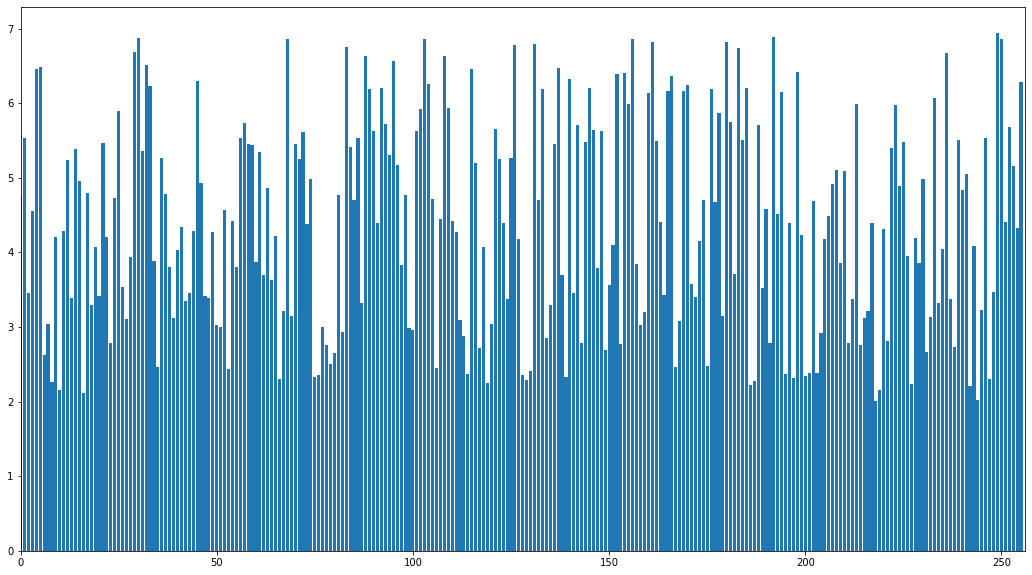

In [502]:
#plt.style.use('_mpl-gallery')

# make data:
np.random.seed(3)
x = np.arange(256)
y = np.random.uniform(2, 7, len(x))

# plot
fig, ax = plt.subplots(figsize=(18, 10))
ax.bar(x, y)

ax.set(xlim=(0, 256))
      

#ax.bar(x, y, width=1, edgecolor="white", linewidth=0.7)

#ax.set(xlim=(0, 8), xticks=np.arange(1, 8),
#       ylim=(0, 8), yticks=np.arange(1, 8))

plt.show()

In [497]:
counts

array([ 66,  19,  26, 147,  88,  15, 140, 100,  65,   7,   5,   3,   5,
         1,  98, 198, 401,   4, 159,  62,   9,  28,  12,  36,  30,   6,
        24, 290,   7, 184, 157, 182, 175,  51,  70,   1,  47,   2,   2,
        10,  31,  38,  16,  24,  56, 142,  23,  23,   1,  20,  30,   6,
        21,  28,   2,  22,   7,   5,  43,  57,   6,  27, 154,   4,  77,
        17, 152,   4,  31,  27,  64,   5,  19,  38,  23,   9,  51,  45,
         4,  42,  29,  39,   8,  18,  22,   1,  14,  11,  73,  58,  69,
       103,  22,  11,  17,   5,  20,  48,   7,   4,   3,   3,   7,  80,
         2], dtype=int64)

In [508]:
arr = np.append(counts,np.zeros(256 - counts.size))

In [509]:
arr.size

256

In [513]:
np.sort(arr)

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   

In [512]:
np.sort(arr)[::2]

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
         1.,   2.,   2.,   3.,   4.,   4.,   4.,   5.,   5.,   6.,   6.,
         7.,   7.,   8.,   9.,  11.,  12.,  15.,  17.,  18.,  19.,  20.,
        22.,  22.,  23.,  24.,  26.,  27.,  28.,  30.,  31.,  36.,  38.,
        42.,  45.,  48.,  51.,  57.,  62.,  65.,  69.,  73.,  80.,  98.,
       103., 142., 152., 157., 175., 184., 290.])

In [515]:
np.sort(arr)[1::2][::-1]

array([401., 198., 182., 159., 154., 147., 140., 100.,  88.,  77.,  70.,
        66.,  64.,  58.,  56.,  51.,  47.,  43.,  39.,  38.,  31.,  30.,
        29.,  28.,  27.,  24.,  23.,  23.,  22.,  21.,  20.,  19.,  17.,
        16.,  14.,  11.,  10.,   9.,   7.,   7.,   7.,   6.,   5.,   5.,
         5.,   4.,   4.,   3.,   3.,   2.,   2.,   1.,   1.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.])

In [516]:
new_plt = np.append(np.sort(arr)[::2], np.sort(arr)[1::2][::-1])
new_plt

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
         1.,   2.,   2.,   3.,   4.,   4.,   4.,   5.,   5.,   6.,   6.,
         7.,   7.,   8.,   9.,  11.,  12.,  15.,  17.,  18.,  19.,  20.,
        22.,  22.,  23.,  24.,  26.,  27.,  28.,  30.,  31.,  36.,  38.,
        42.,  45.,  48.,  51.,  57.,  62.,  65.,  69.,  73.,  80.,  98.,
       103., 142., 152., 157., 175., 184., 290., 401., 198., 182., 159.,
       154., 147., 140., 100.,  88.,  77.,  70.,  66.,  64.,  58.,  56.,
        51.,  47.,  43.,  39.,  38.,  31.,  30.,  2

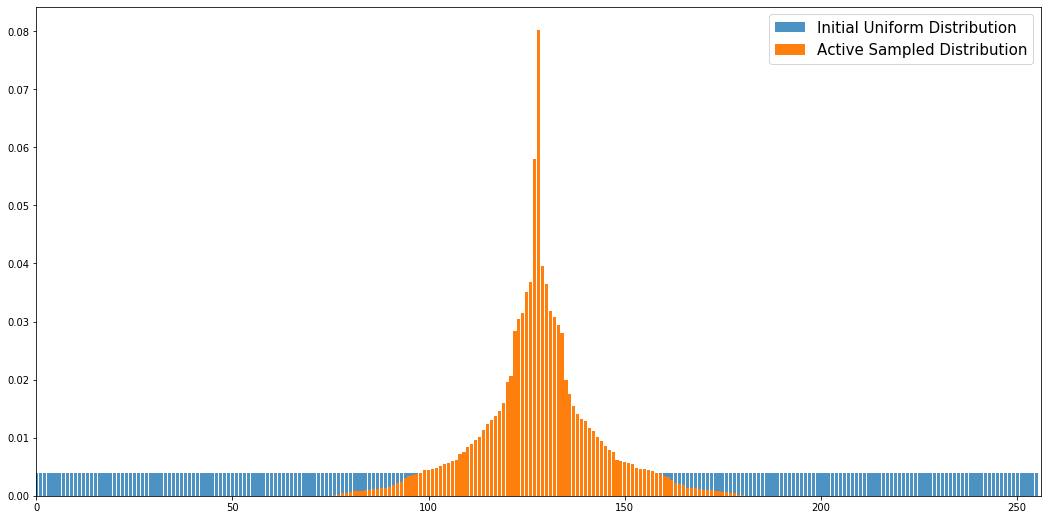

In [533]:
#plt.style.use('_mpl-gallery')

# make data:

x = np.arange(256)
y = new_plt/5000
z = np.ones(256)/256

# plot
fig, ax = plt.subplots(figsize=(18, 9))
ax.bar(x, z, label = "Initial Uniform Distribution", alpha = 0.8)
ax.bar(x, y, label = "Active Sampled Distribution")


ax.set(xlim=(0, 256))
      

#ax.bar(x, y, width=1, edgecolor="white", linewidth=0.7)

#ax.set(xlim=(0, 8), xticks=np.arange(1, 8),
#       ylim=(0, 8), yticks=np.arange(1, 8))

#plt.show()
#plt.legend()
plt.legend(fontsize=15)